# Objective
To address these challenges, we aim to leverage the NYC TLC Trip Record dataset to:

1. Analyze Demand Patterns: Identify peak times, popular routes, and high-demand locations to optimize fleet deployment.
2. Assess Operational Efficiency: Evaluate trip durations, distances, and idle times to improve operational efficiency.
3. Understand Customer Behavior: Analyze passenger counts, payment methods, and tip amounts to gain insights into customer preferences.
4. Revenue Analysis: Break down fare structures and additional charges to identify revenue optimization opportunities.
5. Assess Weather Impact: Evaluate how different weather conditions affect the demand for taxi services to enhance operational decision-making and customer satisfaction.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")
from datetime import timedelta
import folium
from folium.plugins import MarkerCluster
from collections import Counter
import geopandas as gpd
from shapely.geometry import Point, linestring

# Read the data

In [2]:
df = pd.read_csv('Data_CleanedV1.csv', index_col=False)

In [3]:
display(df.head(),df.tail())

,lpep_pickup_datetime,lpep_dropoff_datetime,ratecodeid,pulocationid,puborough,puzone,dolocationid,doborough,dozone,passenger_count,trip_distance,distance_bins,fare_amount,tip_amount,payment_type,trip_type,trip_duration,weather_description
0,2023-01-01 00:26:10,2023-01-01 00:37:11,Standard rate,166,Manhattan,Morningside Heights,143,Manhattan,Lincoln Square West,1.0,2.58,3-6 miles,14.9,4.03,Credit card,1.0,11.02,"Drizzle, not freezing, continuous"
1,2023-01-01 00:51:03,2023-01-01 00:57:49,Standard rate,24,Manhattan,Bloomingdale,43,Manhattan,Central Park,1.0,1.81,<2 miles,10.7,2.64,Credit card,1.0,6.77,"Drizzle, not freezing, continuous"
2,2023-01-01 00:13:14,2023-01-01 00:19:03,Standard rate,41,Manhattan,Central Harlem,238,Manhattan,Upper West Side North,1.0,1.30,<2 miles,6.5,1.70,Credit card,1.0,5.82,"Drizzle, not freezing, continuous"
3,2023-01-01 00:33:04,2023-01-01 00:39:02,Standard rate,41,Manhattan,Central Harlem,74,Manhattan,East Harlem North,1.0,1.10,<2 miles,6.0,0.00,Credit card,1.0,5.97,"Drizzle, not freezing, continuous"
4,2023-01-01 00:53:31,2023-01-01 01:11:04,Standard rate,41,Manhattan,Central Harlem,262,Manhattan,Yorkville East,1.0,2.78,3-6 miles,17.7,0.00,Cash,1.0,17.55,"Drizzle, not freezing, continuous"


,lpep_pickup_datetime,lpep_dropoff_datetime,ratecodeid,pulocationid,puborough,puzone,dolocationid,doborough,dozone,passenger_count,trip_distance,distance_bins,fare_amount,tip_amount,payment_type,trip_type,trip_duration,weather_description
62991,2023-01-31 21:56:00,2023-01-31 22:14:00,Standard rate,75,Manhattan,East Harlem South,186,Manhattan,Penn Station/Madison Sq West,1.0,3.92,3-6 miles,20.72,1.25,Credit card,1.0,18.0,Clouds generally forming or developing
62992,2023-01-31 22:40:00,2023-01-31 22:48:00,Standard rate,10,Queens,Baisley Park,205,Queens,Saint Albans,1.0,2.14,3-6 miles,4.41,0.00,Unknown,1.0,8.0,Clouds generally forming or developing
62993,2023-01-31 23:46:00,2023-02-01 00:02:00,Standard rate,66,Brooklyn,DUMBO/Vinegar Hill,37,Brooklyn,Bushwick South,1.0,3.44,3-6 miles,16.53,3.51,Credit card,1.0,16.0,Clouds generally forming or developing
62994,2023-01-31 23:01:00,2023-01-31 23:19:00,Standard rate,225,Brooklyn,Stuyvesant Heights,189,Brooklyn,Prospect Heights,1.0,3.03,3-6 miles,14.98,3.20,Credit card,1.0,18.0,Clouds generally forming or developing
62995,2023-01-31 23:51:00,2023-02-01 00:07:00,Standard rate,256,Brooklyn,Williamsburg (South Side),140,Manhattan,Lenox Hill East,1.0,5.82,3-6 miles,23.65,2.00,Credit card,1.0,16.0,Clouds generally forming or developing


In [4]:
df.dtypes

lpep_pickup_datetime      object
lpep_dropoff_datetime     object
ratecodeid                object
pulocationid               int64
puborough                 object
puzone                    object
dolocationid               int64
doborough                 object
dozone                    object
passenger_count           object
trip_distance            float64
distance_bins             object
fare_amount              float64
tip_amount               float64
payment_type              object
trip_type                float64
trip_duration            float64
weather_description       object
dtype: object

# Identify Peak Times

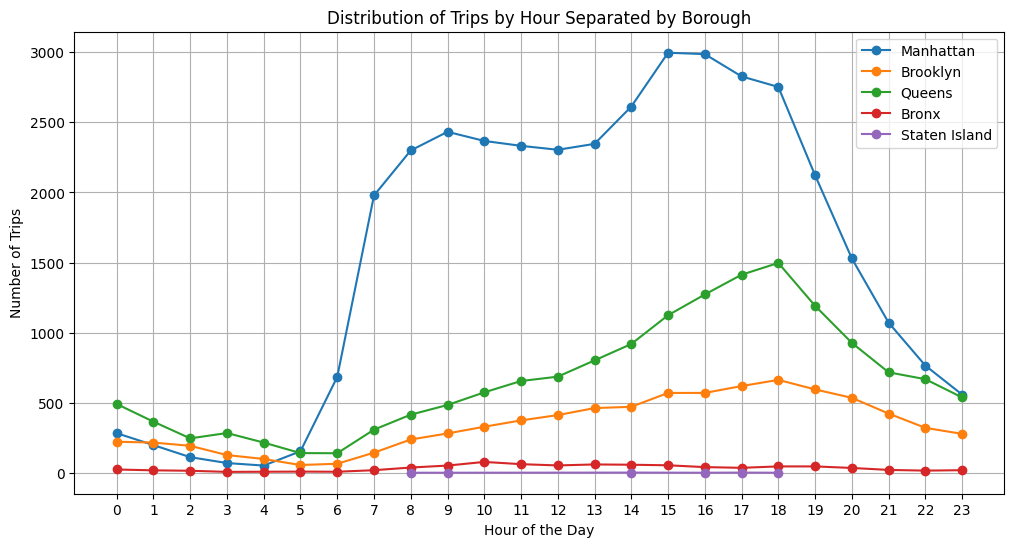

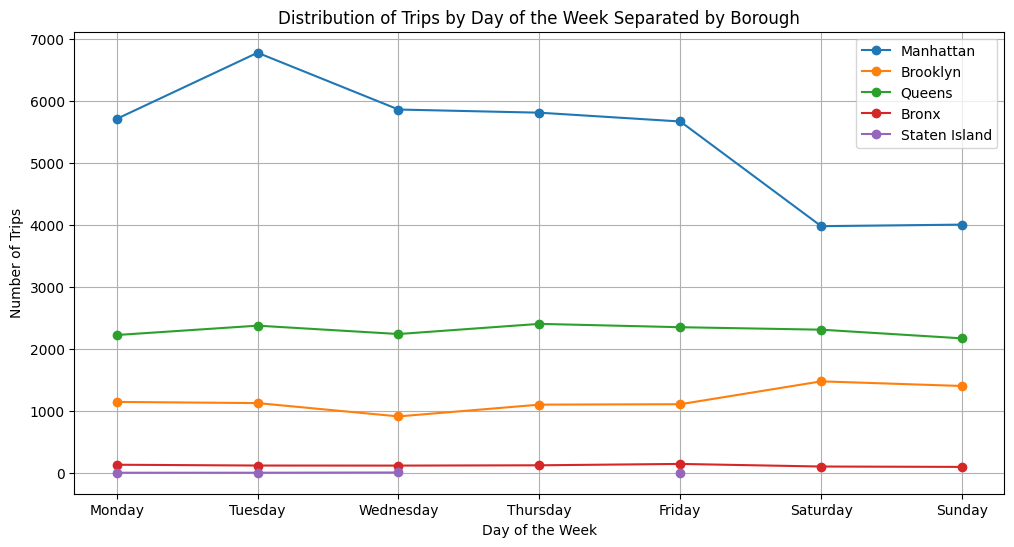

In [5]:
df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])

df['pickup_hour'] = df['lpep_pickup_datetime'].dt.hour
df['pickup_day'] = df['lpep_pickup_datetime'].dt.day_name()

hourly_counts = df['pickup_hour'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
for borough in df['puborough'].unique():
    hourly_counts = df[df['puborough'] == borough]['pickup_hour'].value_counts().sort_index()
    plt.plot(hourly_counts.index, hourly_counts.values, marker='o', label=borough)
plt.title('Distribution of Trips by Hour Separated by Borough')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Trips')
plt.xticks(range(24))
plt.legend()
plt.grid(True)
plt.show()

daily_counts = df['pickup_day'].value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(12, 6))
for borough in df['puborough'].unique():
    daily_counts = df[df['puborough'] == borough]['pickup_day'].value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    plt.plot(daily_counts.index, daily_counts.values, marker='o', label=borough)
plt.title('Distribution of Trips by Day of the Week Separated by Borough')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# Create a contingency table for hours
hour_counts = df['pickup_hour'].value_counts().sort_index()
# Create expected frequencies assuming uniform distribution
expected_hour_counts = [hour_counts.sum() / len(hour_counts)] * len(hour_counts)

# Perform chi-square test for hours
chi2_hour, p_hour = stats.chisquare(hour_counts, f_exp=expected_hour_counts)
print(f"Chi-Square Test for Hours: chi2 = {chi2_hour}, p-value = {p_hour}")

# Create a contingency table for days
day_counts = df['pickup_day'].value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
# Create expected frequencies assuming uniform distribution
expected_day_counts = [day_counts.sum() / len(day_counts)] * len(day_counts)

# Perform chi-square test for days
chi2_day, p_day = stats.chisquare(day_counts, f_exp=expected_day_counts)
print(f"Chi-Square Test for Days: chi2 = {chi2_day}, p-value = {p_day}")

Chi-Square Test for Hours: chi2 = 22071.350815924816, p-value = 0.0
Chi-Square Test for Days: chi2 = 592.3935805447966, p-value = 1.0196041112510875e-124


Chi-Square Test for Hours: The extremely high chi-square value and the p-value of 0.0 indicate that the distribution of trips by hour is significantly different from a uniform distribution. This strongly suggests that there are specific peak hours with much higher demand.

Chi-Square Test for Days: The high chi-square value and the very small p-value indicate that the distribution of trips by day of the week is also significantly different from a uniform distribution. This implies that certain days have higher demand compared to others.

# Identify Popular Routes

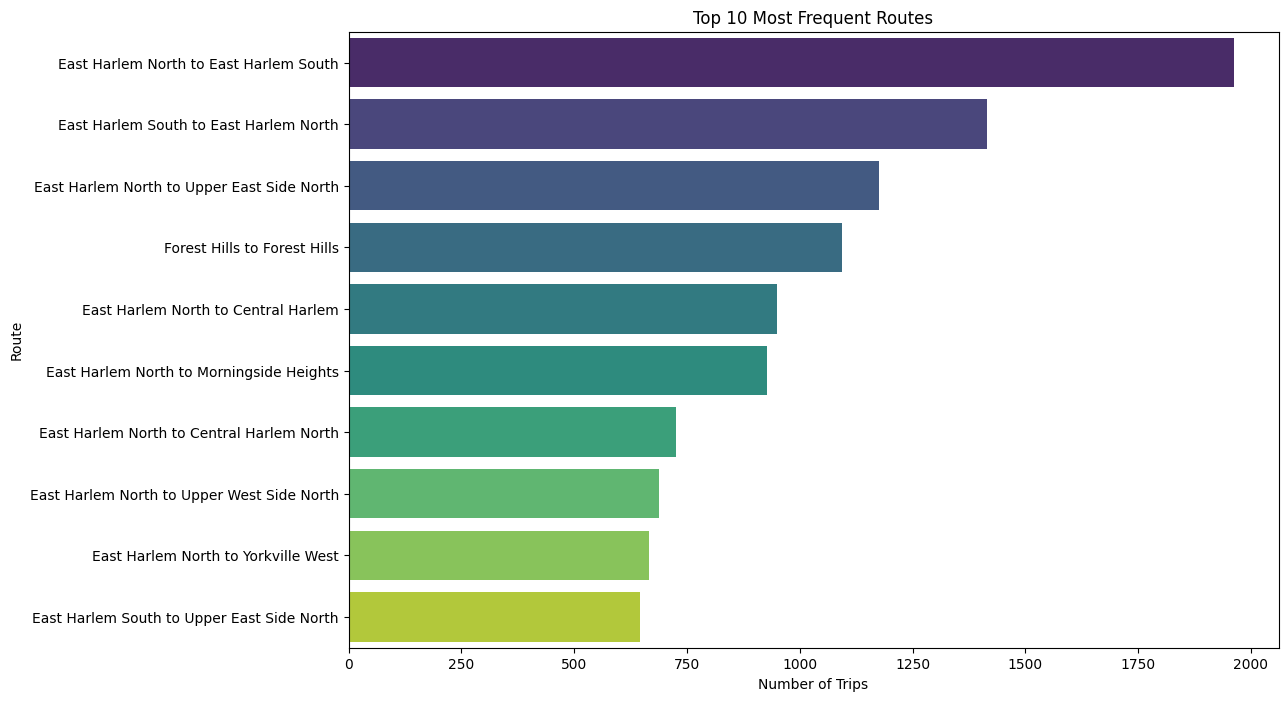

In [7]:
df['route_zone'] = df['puzone'] + ' to ' + df['dozone']

top_routes_zone = df['route_zone'].value_counts().head(10)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_routes_zone.values, y=top_routes_zone.index, palette="viridis")
plt.title('Top 10 Most Frequent Routes')
plt.xlabel('Number of Trips')
plt.ylabel('Route')
plt.show()

# Identify High-Demand Locations

- Frequent Pickup Zones

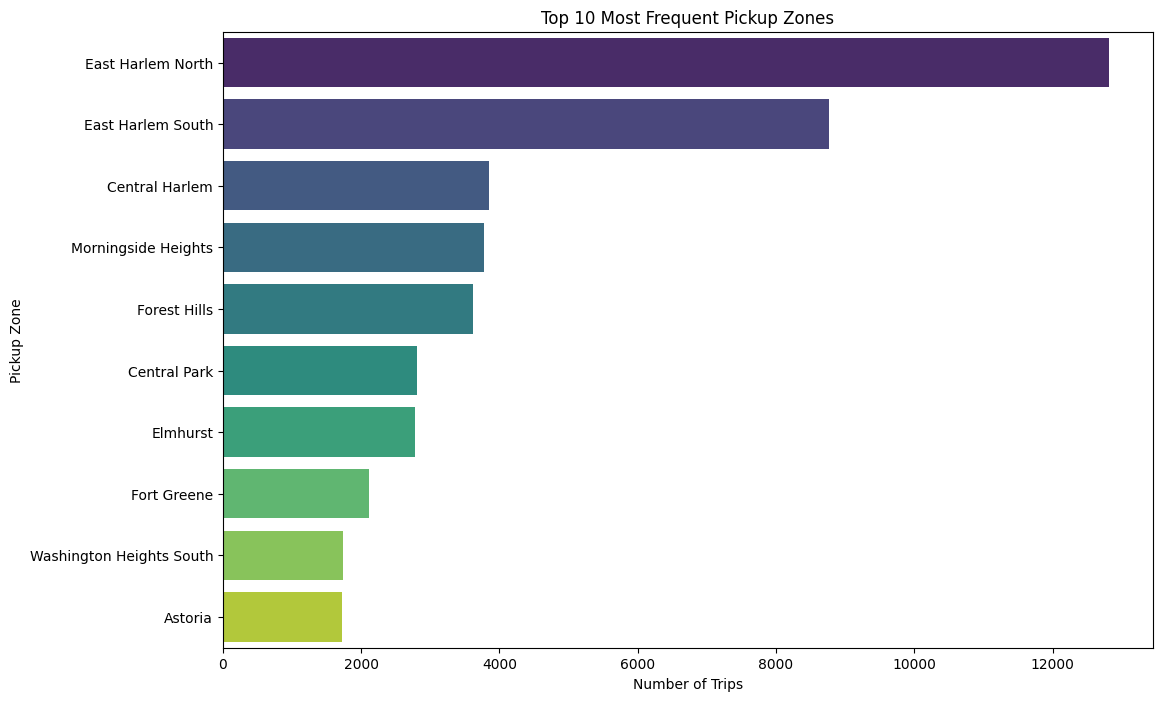

In [8]:
top_pickup_zones = df['puzone'].value_counts().head(10)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_pickup_zones.values, y=top_pickup_zones.index, palette="viridis")
plt.title('Top 10 Most Frequent Pickup Zones')
plt.xlabel('Number of Trips')
plt.ylabel('Pickup Zone')
plt.show()

Chi Square test for pickup zones

In [9]:
pickup_counts = df['puzone'].value_counts()

expected_pickup_counts = [pickup_counts.sum() / len(pickup_counts)] * len(pickup_counts)

chi2_pickup, p_pickup = stats.chisquare(f_obs=pickup_counts, f_exp=expected_pickup_counts)
print(f"Chi-Square Test for Pickup Zones: chi2 = {chi2_pickup}, p-value = {p_pickup}")

Chi-Square Test for Pickup Zones: chi2 = 915762.1248333226, p-value = 0.0


The extremely high chi-square value and the p-value of 0.0 indicate that the distribution of trips among the pickup zones is significantly different from a uniform distribution. This strongly suggests that certain pickup zones have significantly higher trip counts compared to others.

- Frequent Dropoff Zones

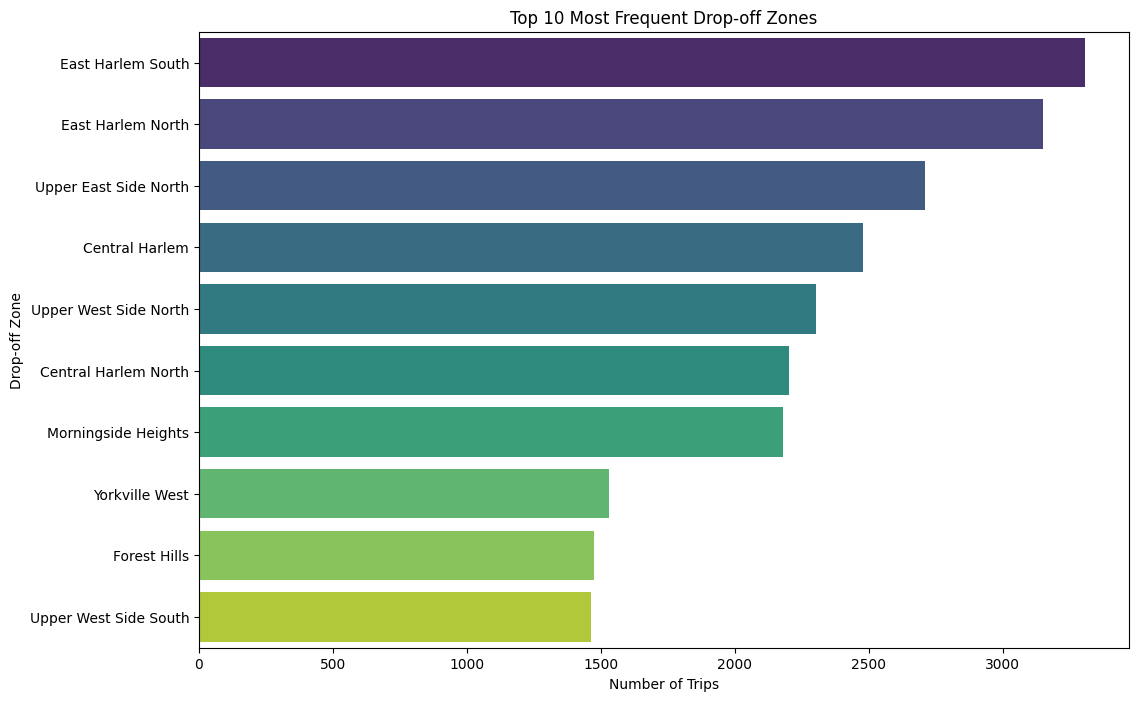

In [10]:
top_dropoff_zones = df['dozone'].value_counts().head(10)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_dropoff_zones.values, y=top_dropoff_zones.index, palette="viridis")
plt.title('Top 10 Most Frequent Drop-off Zones')
plt.xlabel('Number of Trips')
plt.ylabel('Drop-off Zone')
plt.show()


Chi Square Test for Drop-off zones

In [11]:
dropoff_counts = df['dozone'].value_counts()

expected_dropoff_counts = [dropoff_counts.sum() / len(dropoff_counts)] * len(dropoff_counts)

chi2_dropoff, p_dropoff = stats.chisquare(f_obs=dropoff_counts, f_exp=expected_dropoff_counts)
print(f"Chi-Square Test for Drop-off Zones: chi2 = {chi2_dropoff}, p-value = {p_dropoff}")


Chi-Square Test for Drop-off Zones: chi2 = 236420.72423645947, p-value = 0.0


The high chi-square value and the p-value of 0.0 indicate that the distribution of trips among the drop-off zones is significantly different from a uniform distribution. This strongly suggests that certain drop-off zones have significantly higher trip counts compared to others.

# Assess Operational Efficiency

- Evaluate Trip Duration

In [12]:
trip_duration_stats = df['trip_duration'].describe()
trip_duration_stats

count    62996.000000
mean        13.826917
std          9.522405
min          2.020000
25%          7.570000
50%         11.530000
75%         17.270000
max        182.530000
Name: trip_duration, dtype: float64

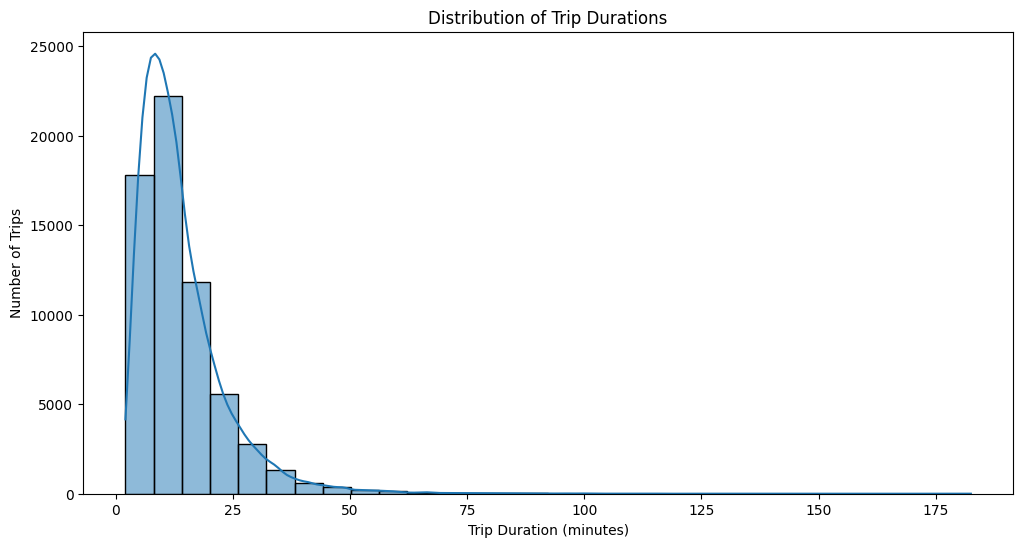

In [13]:
plt.figure(figsize=(12, 6))
sns.histplot(df['trip_duration'], bins=30, kde=True)
plt.title('Distribution of Trip Durations')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Number of Trips')
plt.show()


- Evaluate Trip Distances

In [14]:
trip_distance_stats = df['trip_distance'].describe()
trip_distance_stats

count    62996.000000
mean         2.800240
std          2.608467
min          0.210000
25%          1.260000
50%          1.960000
75%          3.340000
max         41.740000
Name: trip_distance, dtype: float64

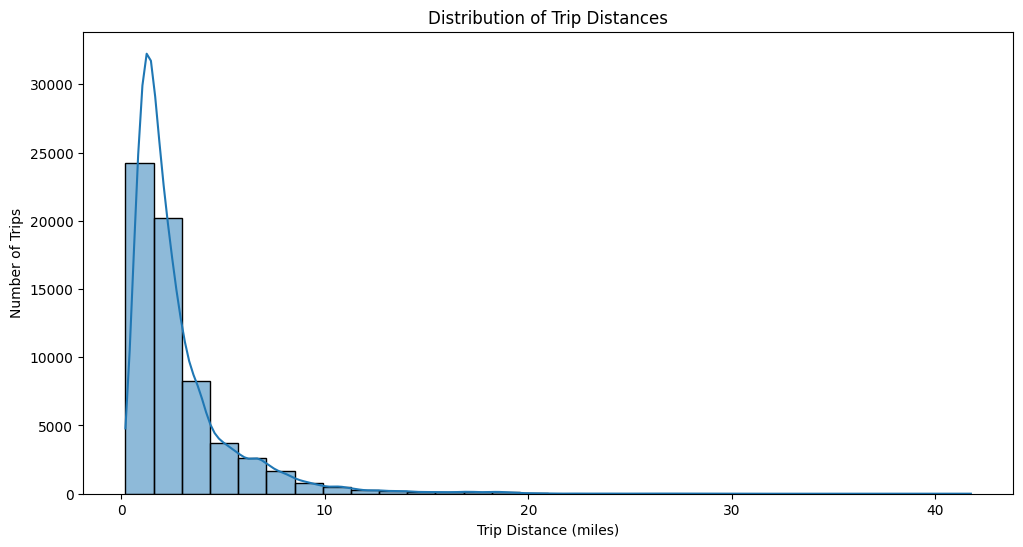

In [15]:
plt.figure(figsize=(12, 6))
sns.histplot(df['trip_distance'], bins=30, kde=True)
plt.title('Distribution of Trip Distances')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Number of Trips')
plt.show()

Summary of Operational Efficiency:
- Trip Durations:
    The average trip duration is about 14.34 minutes.
    Most trips fall within the range of 8.02 to 17.72 minutes (25th to 75th percentile).
- Trip Distances:
    The average trip distance is about 2.95 miles.
    Most trips fall within the range of 1.33 to 3.48 miles (25th to 75th percentile).

# Insight

1. Optimize Fleet Deployment
    * Short Trip Clustering: Since most trips are short in duration (around 14 minutes) and distance (around 2. 95 miles), taxis can be clustered in high-demand areas to quickly respond to new trip requests, minimizing idle times and maximizing the number of trips per shift.
    * Peak Hours Adjustment: Deploy more taxis during peak hours identified from the demand pattern analysis to ensure availability and reduce passenger wait times.
2. Route Optimization
    * High-Demand Routes: Focus on optimizing routes for high-demand pickup and drop-off zones to reduce travel time and increase the efficiency of each trip.
    * Navigation Support: Provide drivers with real-time navigation support to avoid traffic and choose the most efficient routes, especially for short trips.

# Understanding Customer Behaviour

Passenger Counts Analysis

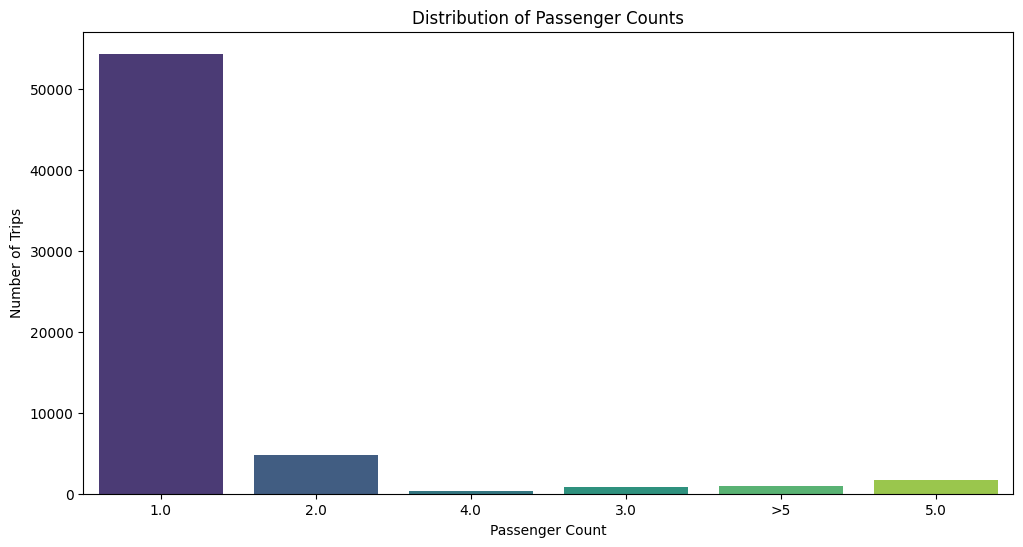

In [16]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='passenger_count', palette="viridis")
plt.title('Distribution of Passenger Counts')
plt.xlabel('Passenger Count')
plt.ylabel('Number of Trips')
plt.show()


Insight :
* Most trips (about 86%) are single-passenger trips.
* Trips with two passengers make up about 7.5% of the total trips.
* Trips with more than three passengers and exactly three passengers are relatively rare.

Payment Method Analysis

In [17]:
payment_methods = df['payment_type'].value_counts()
payment_methods

payment_type
Credit card    41367
Cash           21045
Unknown          429
No charge        130
Dispute           25
Name: count, dtype: int64

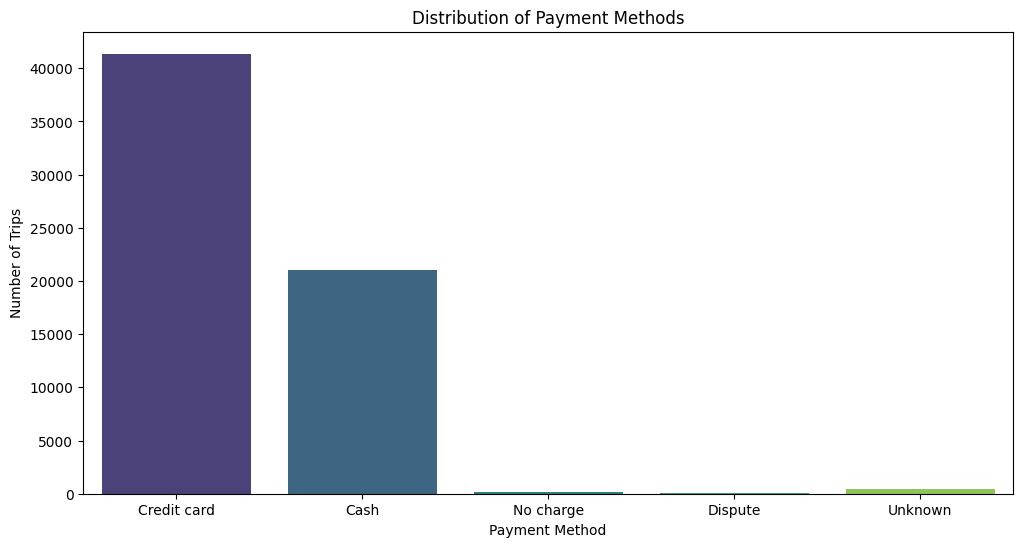

In [18]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='payment_type', palette="viridis")
plt.title('Distribution of Payment Methods')
plt.xlabel('Payment Method')
plt.ylabel('Number of Trips')
plt.show()

Insight :
* The majority of trips (approximately 66%) are paid for using credit cards.
* Cash payments account for about 33% of the trips.
* Other payment methods (Unknown, No Charge, Dispute) are relatively rare.

Tip Amounts Analysis

In [19]:
tip_amount_stats = df['tip_amount'].describe()
tip_amount_stats

count    62996.000000
mean         2.214784
std          2.954265
min          0.000000
25%          0.000000
50%          1.880000
75%          3.420000
max        222.220000
Name: tip_amount, dtype: float64

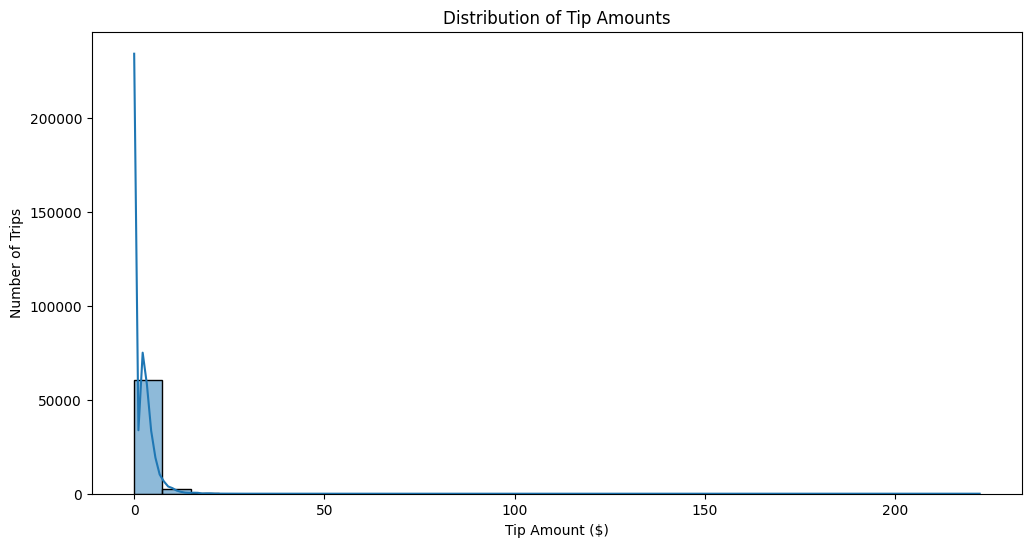

In [20]:
plt.figure(figsize=(12, 6))
sns.histplot(df['tip_amount'], bins=30, kde=True)
plt.title('Distribution of Tip Amounts')
plt.xlabel('Tip Amount ($)')
plt.ylabel('Number of Trips')
plt.show()

Insight :
* The average tip amount is $2.27, with a median of $2.00.
* A significant portion of trips have no tip.
* The maximum recorded tip amount is $222.00.

# Revenue Analysis

In [21]:
fare_amount_stats = df['fare_amount'].describe()
fare_amount_stats

count    62996.000000
mean        16.309743
std         10.813255
min          2.500000
25%          9.300000
50%         13.500000
75%         19.470000
max        162.600000
Name: fare_amount, dtype: float64

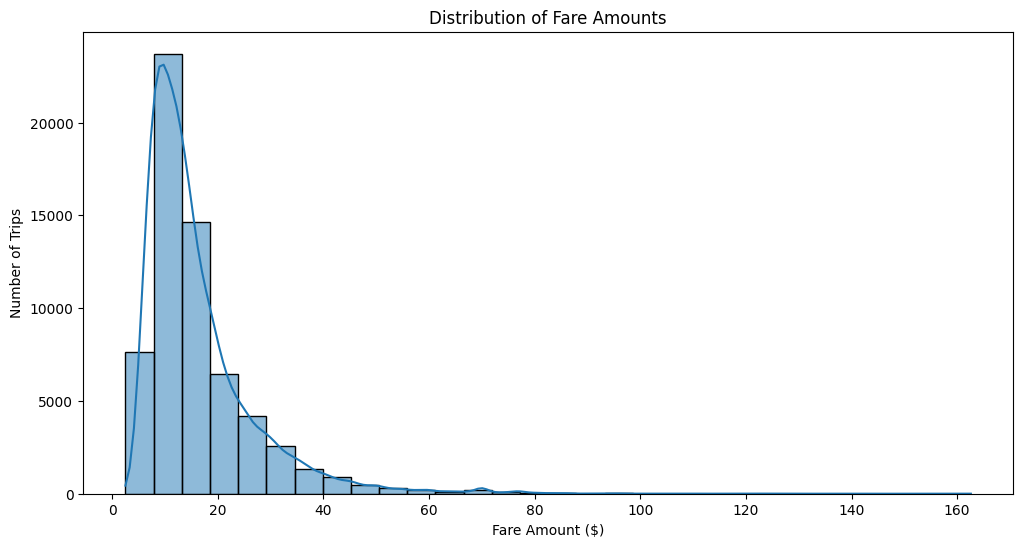

In [22]:
plt.figure(figsize=(12, 6))
sns.histplot(df['fare_amount'], bins=30, kde=True)
plt.title('Distribution of Fare Amounts')
plt.xlabel('Fare Amount ($)')
plt.ylabel('Number of Trips')
plt.show()

Insight
* The average fare amount is $16.30, with a median of $13.50, indicating that most fares are relatively moderate.
* The fare amounts have a wide range, with some trips costing as little as $2.50 and others as much as $162.60.
* The 25th to 75th percentile range ($9.30 to $19.47) shows where the middle 50% of fares lie, which can be useful for setting pricing strategies.

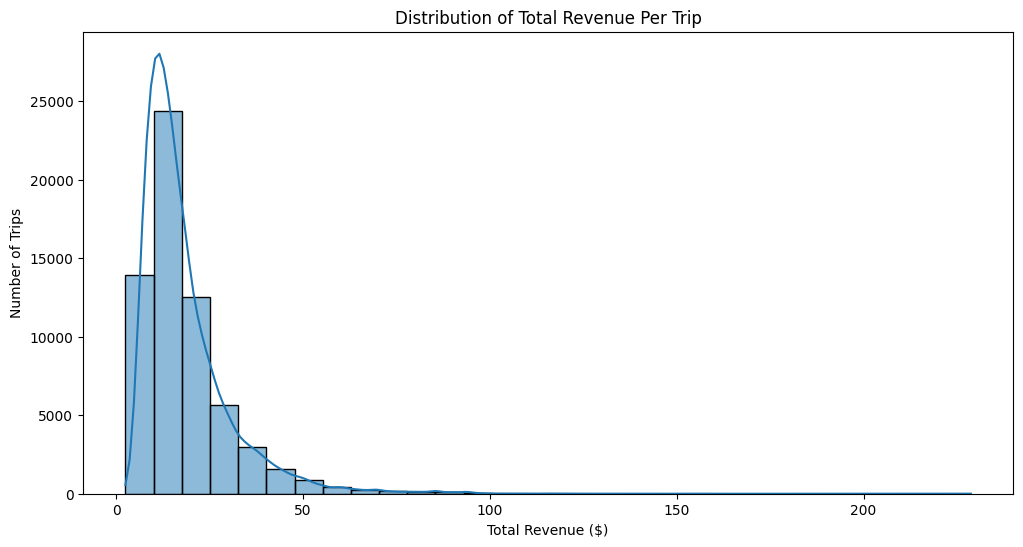

In [23]:
df['total_revenue'] = df['fare_amount'] + df['tip_amount']

plt.figure(figsize=(12, 6))
sns.histplot(df['total_revenue'], bins=30, kde=True)
plt.title('Distribution of Total Revenue Per Trip')
plt.xlabel('Total Revenue ($)')
plt.ylabel('Number of Trips')
plt.show()

Identification of High Revenue Zone

In [24]:
pickup_revenue = df.groupby('puzone')['total_revenue'].mean().sort_values(ascending=False)
pickup_revenue


puzone
Sutton Place/Turtle Bay North          94.460000
World Trade Center                     93.150000
Upper West Side South                  70.500000
Far Rockaway                           67.356667
Bellerose                              61.200000
                                         ...    
West Brighton                          11.500000
Hollis                                 11.413846
Madison                                 9.875000
Saint Michaels Cemetery/Woodside        7.900000
Breezy Point/Fort Tilden/Riis Beach     7.200000
Name: total_revenue, Length: 191, dtype: float64

In [25]:
dropoff_revenue = df.groupby('dozone')['total_revenue'].mean().sort_values(ascending=False)
dropoff_revenue


dozone
Newark Airport                         121.344375
Breezy Point/Fort Tilden/Riis Beach     86.350000
JFK Airport                             59.392780
City Island                             54.900000
Pelham Bay Park                         54.800000
                                          ...    
Central Harlem North                    11.688834
Westerleigh                             11.500000
East Harlem North                       10.878352
Central Harlem                          10.486710
Saint George/New Brighton                8.950000
Name: total_revenue, Length: 242, dtype: float64

In [26]:
top_10_pickup_revenue_zones = pickup_revenue.head(10)

top_10_dropoff_revenue_zones = dropoff_revenue.head(10)

top_10_pickup_revenue_zones, top_10_dropoff_revenue_zones


(puzone
 Sutton Place/Turtle Bay North    94.460000
 World Trade Center               93.150000
 Upper West Side South            70.500000
 Far Rockaway                     67.356667
 Bellerose                        61.200000
 Randalls Island                  60.000000
 Cambria Heights                  59.301000
 Bath Beach                       57.650000
 Bloomfield/Emerson Hill          56.600000
 West Chelsea/Hudson Yards        56.270000
 Name: total_revenue, dtype: float64,
 dozone
 Newark Airport                         121.344375
 Breezy Point/Fort Tilden/Riis Beach     86.350000
 JFK Airport                             59.392780
 City Island                             54.900000
 Pelham Bay Park                         54.800000
 Bellerose                               52.406667
 Hammels/Arverne                         50.261667
 Borough Park                            44.948421
 Rockaway Park                           44.206667
 Bay Ridge                               42.037

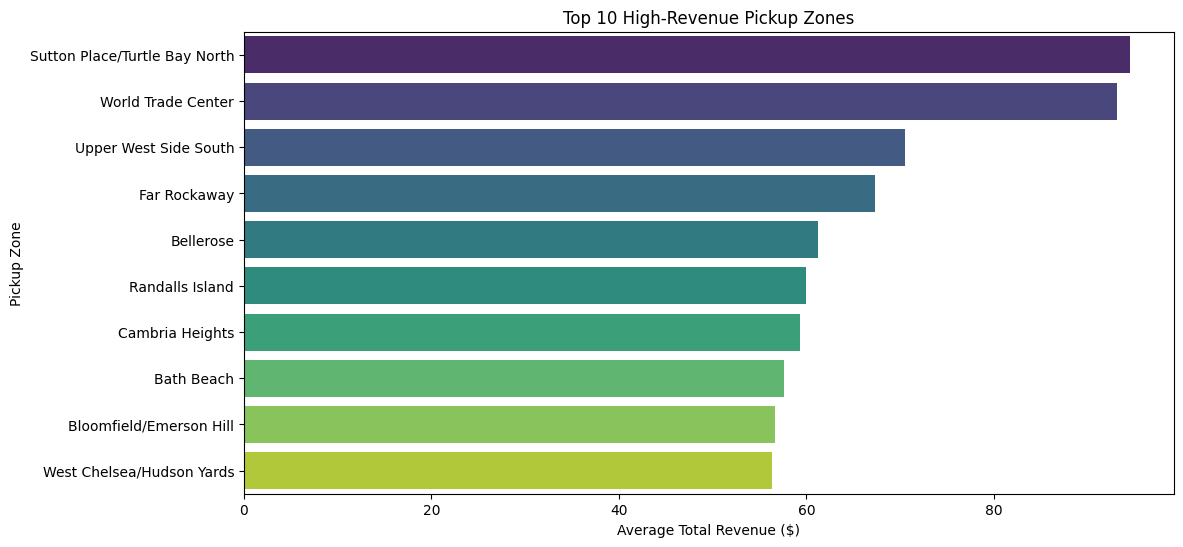

In [27]:
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_pickup_revenue_zones.values, y=top_10_pickup_revenue_zones.index, palette="viridis")
plt.title('Top 10 High-Revenue Pickup Zones')
plt.xlabel('Average Total Revenue ($)')
plt.ylabel('Pickup Zone')
plt.show()

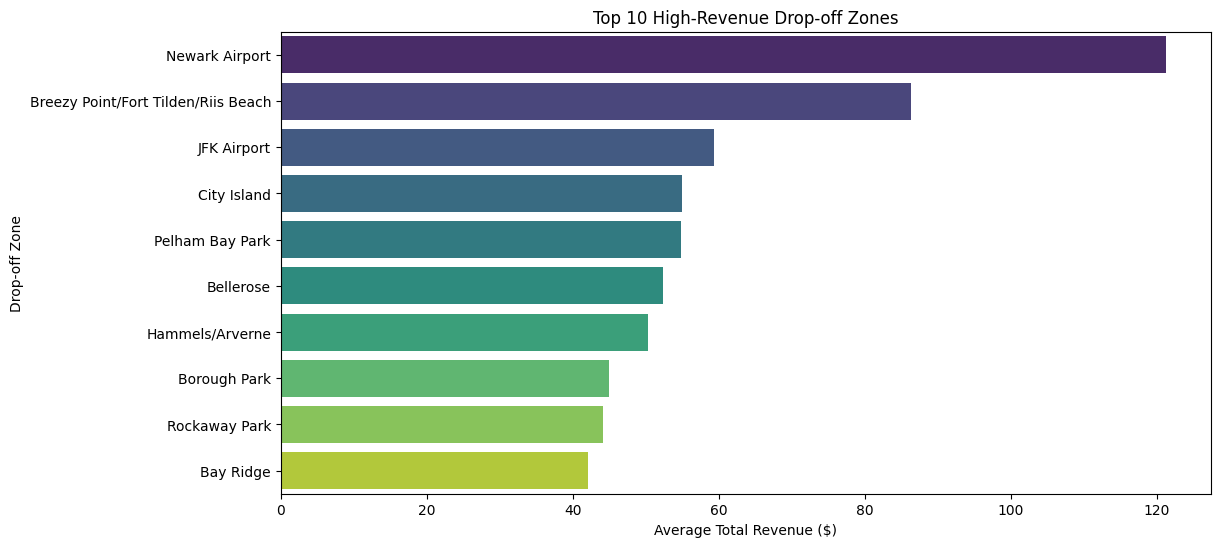

In [28]:
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_dropoff_revenue_zones.values, y=top_10_dropoff_revenue_zones.index, palette="viridis")
plt.title('Top 10 High-Revenue Drop-off Zones')
plt.xlabel('Average Total Revenue ($)')
plt.ylabel('Drop-off Zone')
plt.show()

# Assessment of Weather impacting number of trips

In [29]:
# Define weather condition categories based on existing column 'weather_description'
def categorize_weather(description):
    description = description.lower()
    if any(word in description for word in ['clear', 'cloud']):
        return 'Clear'
    elif any(word in description for word in ['rain', 'drizzle']):
        return 'Rainy'
    elif any(word in description for word in ['snow']):
        return 'Snowy'
    else:
        return 'Other'

df['weather_category'] = df['weather_description'].apply(categorize_weather)


In [30]:
weather_demand = df['weather_category'].value_counts()

weather_revenue = df.groupby('weather_category')['total_revenue'].mean()

weather_demand, weather_revenue


(weather_category
 Clear    43835
 Rainy    12101
 Other     6145
 Snowy      915
 Name: count, dtype: int64,
 weather_category
 Clear    18.481844
 Other    18.492858
 Rainy    18.732701
 Snowy    18.028907
 Name: total_revenue, dtype: float64)

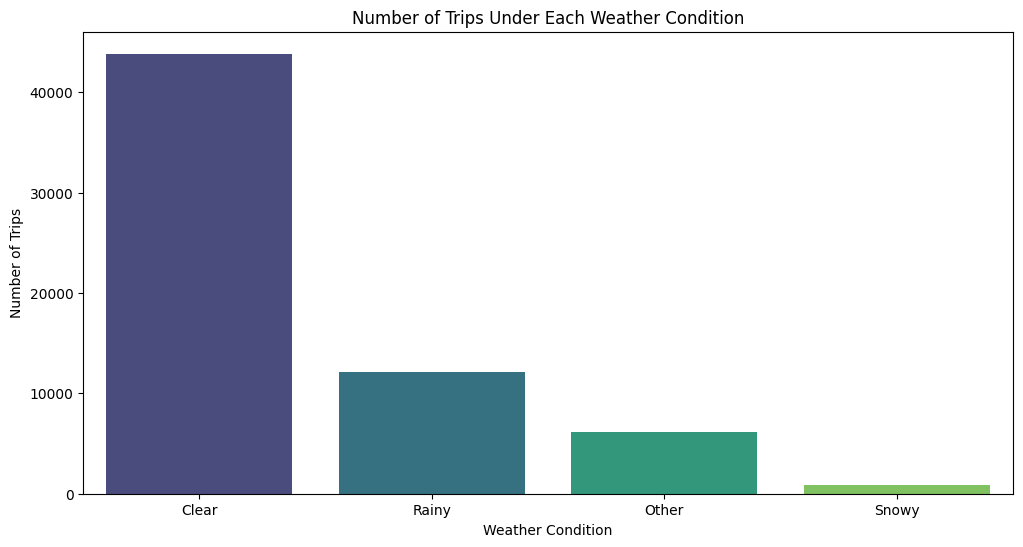

In [31]:
# Plot the number of trips under each weather condition
plt.figure(figsize=(12, 6))
sns.barplot(x=weather_demand.index, y=weather_demand.values, palette="viridis")
plt.title('Number of Trips Under Each Weather Condition')
plt.xlabel('Weather Condition')
plt.ylabel('Number of Trips')
plt.show()

In [32]:
# Filter the data to show only rows where weather category is 'Other'
other_weather_data = df[df['weather_category'] == 'Other']

# Display the unique weather descriptions in the 'Other' category
unique_other_descriptions = other_weather_data['weather_description'].unique()
unique_other_descriptions


array(['State of sky on the whole unchanged'], dtype=object)

In [33]:
# Find all rows where the weather description is "State of sky on the whole unchanged"
other_weather_indices = df[df['weather_description'] == 'State of sky on the whole unchanged'].index

In [34]:
# Def function to replace the "State of sky on the whole unchanged" description
def find_valid_weather_description(row):
    current_time = row['lpep_pickup_datetime']
    one_hour_earlier = current_time - timedelta(hours=1)

    potential_matches = df[(df['lpep_pickup_datetime'] >= one_hour_earlier) & 
                           (df['lpep_pickup_datetime'] < current_time) & 
                           (df['weather_description'] != 'State of sky on the whole unchanged')]
    
    if not potential_matches.empty:
        return potential_matches.iloc[0]['weather_description']
    return row['weather_description']


while True:
    other_weather_indices = df[df['weather_description'] == 'State of sky on the whole unchanged'].index
    if len(other_weather_indices) == 0:
        break
    df.loc[other_weather_indices, 'weather_description'] = df.loc[other_weather_indices].apply(find_valid_weather_description, axis=1)



In [35]:
df['weather_category'] = df['weather_description'].apply(categorize_weather)

In [36]:
weather_demand = df['weather_category'].value_counts()

weather_demand


weather_category
Clear    49748
Rainy    12333
Snowy      915
Name: count, dtype: int64

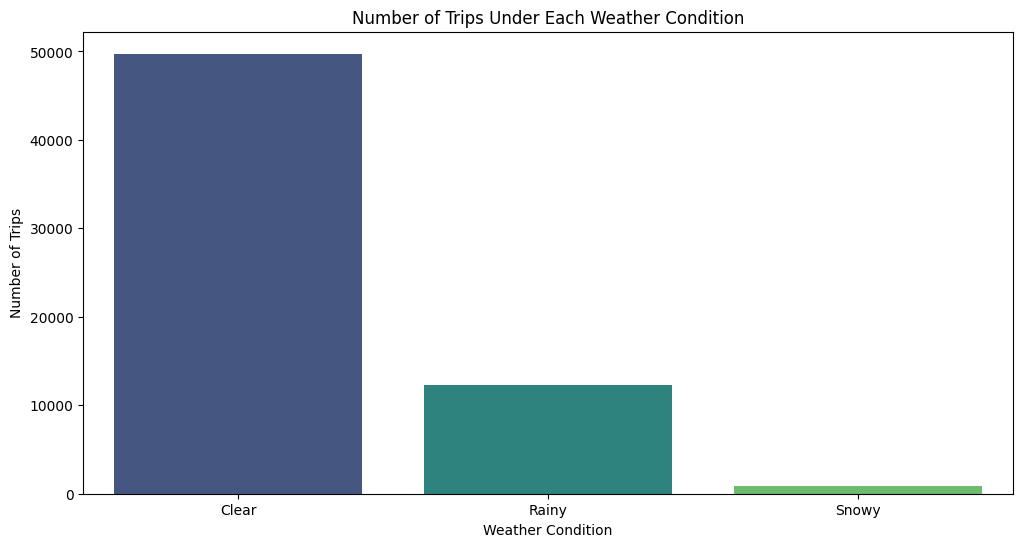

In [37]:
plt.figure(figsize=(12, 6))
sns.barplot(x=weather_demand.index, y=weather_demand.values, palette="viridis")
plt.title('Number of Trips Under Each Weather Condition')
plt.xlabel('Weather Condition')
plt.ylabel('Number of Trips')
plt.show()

From the plot above, we can see that majority of the trips is happen during clear weather condition

### Summary of Recommendations from the Analysis

#### 1. **Analyze Demand Patterns**
- **Identify Peak Times**: Analyze hourly and daily demand patterns to optimize fleet deployment.
    Peak Hours Optimization:
      Deploy more taxis during peak hours (7 AM to 7 PM) to meet higher demand.
- **Popular Routes**: Identify high-demand routes to ensure adequate taxi availability.

#### 2. **Assess Operational Efficiency**
- **Optimize Fleet Deployment**:
  - **Short Trip Clustering**: Cluster taxis in high-demand areas to quickly respond to new trip requests, minimizing idle times and maximizing trips per shift.
  - **Peak Hours Adjustment**: Deploy more taxis during peak hours identified from the demand pattern analysis to ensure availability and reduce passenger wait times.
- **Dynamic Pricing Strategies**:
  - **Surge Pricing**: Implement dynamic pricing during peak hours or in high-demand zones to manage demand and supply effectively.
  - **Short Trip Discounts**: Offer discounts or incentives for short trips to encourage more frequent use of taxis for short distances, increasing overall trip numbers.
- **Route Optimization**:
  - **High-Demand Routes**: Optimize routes for high-demand pickup and drop-off zones to reduce travel time and increase trip efficiency.
  - **Navigation Support**: Provide drivers with real-time navigation support to avoid traffic and choose the most efficient routes.
- **Fleet Management**:
  - **Maintenance Scheduling**: Schedule regular maintenance during off-peak hours to ensure maximum availability during high-demand periods.
  - **Fleet Size Adjustment**: Adjust the fleet size based on demand patterns, having more taxis available during weekends if the data indicates higher demand on those days.
- **Customer Satisfaction**:
  - **Reduce Wait Times**: Optimize the deployment of taxis and offer dynamic pricing to reduce passenger wait times.
  - **Feedback Collection**: Collect feedback from passengers to understand their preferences and adjust services accordingly.

#### 3. **Understand Customer Behavior**
- **Incentivize Tipping**:
  - **Encourage Higher Tips**: Implement strategies to encourage tipping, such as suggesting tip amounts in payment interfaces or offering rewards for passengers who tip well.
  - **Promotions and Upsells**: Offer promotions or discounts for passengers who tip above a certain threshold.
- **Enhance Credit Card Payment Systems**:
  - **Ensure Seamless Payment**: Maintain secure and reliable credit card payment systems, as a majority of customers prefer this method.
  - **Offer Incentives**: Provide incentives for using digital payments to increase their adoption.
- **Focus on Single-Passenger Services**:
  - **Optimize Services for Single Passengers**: Target services and promotions towards single-passenger trips, which are the most common.
  - **Loyalty Programs**: Introduce loyalty programs or discounts for frequent single-passenger trips.
- **Analyze Cash Payment Preferences**:
  - **Offer Incentives for Digital Payments**: Provide incentives for passengers to switch from cash to digital payments for easier tracking and security.

#### 4. **Revenue Analysis**
- **Increase Average Revenue per Trip**:
  - **Encourage Higher Tips**: Implement suggested tip amounts in payment interfaces and offer promotions to encourage higher tipping.
  - **Promotions and Upsells**: Offer promotions for longer trips or upsell additional services, such as premium car options or in-car amenities.
- **Target High Revenue Zones**:
  - **Identify High Revenue Routes**: Focus on optimizing taxi availability in high-revenue zones.
  - **Dynamic Pricing**: Implement dynamic pricing strategies for high-demand zones during peak times to maximize revenue.
- **Implement Loyalty Programs**:
  - **Frequent Rider Rewards**: Create loyalty programs to reward frequent riders, encouraging repeat business and higher spending per trip.
  - **Referral Programs**: Encourage current customers to refer new riders through referral incentives, expanding the customer base and increasing revenue.

#### 5. **High-Demand Locations**
- **Increase Taxi Availability**: Ensure that taxis are readily available in high-demand pickup and drop-off zones.
- **Optimize Fleet Deployment**: Deploy more taxis in high-demand areas to reduce passenger wait times and increase trip numbers.

#### 6. **Weather Impact on Demand**
- **Increase Taxi Availability During Rainy Weather**:
  - **Meet Higher Demand**: Increase the availability of taxis during rain to meet higher demand.
  - **Surge Pricing**: Implement surge pricing during rain to optimize revenue.
- **Prepare for Snowy Weather**:
  - **Ensure Safe Travel**: Equip taxis for safe travel in snowy conditions to maintain service quality.
  - **Offer Promotions**: Encourage travel during snowy weather through promotions.
- **Maintain Steady Supply During Clear Weather**:
  - **Regular Demand**: Maintain a steady supply of taxis to meet regular demand during clear weather.
- **Enhance Customer Experience**:
  - **Weather-Specific Services**: Provide amenities like umbrellas during rainy weather or heated seats during snowy weather to improve passenger satisfaction.

### Overall Recommendations
1. **Data-Driven Scheduling**: Use data to create schedules that deploy taxis based on demand patterns, ensuring optimal coverage during peak times and in high-demand zones.
2. **Real-Time Monitoring**: Implement real-time monitoring to track taxi locations, trip durations, and distances, and adjust deployment dynamically.
3. **Driver Incentive Programs**: Develop incentive programs to encourage drivers to work during peak hours and in high-demand zones.
4. **Customer Loyalty Programs**: Create programs to offer discounts or rewards for frequent users, particularly for short trips, to increase ridership and customer retention.
5. **Enhanced Driver Training**: Provide training focused on efficient route selection, customer service, and technology use to improve overall service quality.

In [38]:
#df.to_excel('Final Data.xlsx', index=False)